## loading image

In [41]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

#Import image
image = cv2.imread("face.jpg")

#Show the image with matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## convert image to gray scale

In [ ]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
thresh2 = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 199, 5)
plt.imshow(cv2.cvtColor(thresh2, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
ok,thresh2=cv2.threshold(gray_image, 120, 255, cv2.THRESH_TOZERO)
plt.imshow(cv2.cvtColor(thresh2, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
minValue = 70
frame=image
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #gray scale
blur = cv2.GaussianBlur(gray,(5,5),2) #gaussian blur
th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2) #adaptive inversion
ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #binary inversion
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
def process(image_name):
    image = cv2.imread(image_name)
    #Show the image with matplotlib
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
process("frame.png")

In [ ]:
import cv2
def getFrames(file):
    vidcap=cv2.VideoCapture(file) #capture and read the video file
    success,image=vidcap.read()
    while success:
        cv2.imwrite("frame.png",image)
        process("frame.png") #this is the image processing function "process" where the frames are sent
        success,image=vidcap.read()
        break

In [ ]:
import moviepy.editor as mp

In [ ]:
def getAudio(file):
    my_clip = mp.VideoFileClip(file)
    my_clip.audio.write_audiofile(r"finally.mp3")


In [ ]:
def runApplication(fileName):
    getFrames(fileName)
    getAudio(fileName) #audio is written in finally.mp3 and sent to meetingOWL project [done]
runApplication("sample.mp4")

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical




In [ ]:
data = pd.read_csv('icml_face_data.csv')
#48 x 48

In [ ]:
data.head()


In [ ]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [ ]:
data[' Usage'].value_counts()


In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [ ]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [42]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

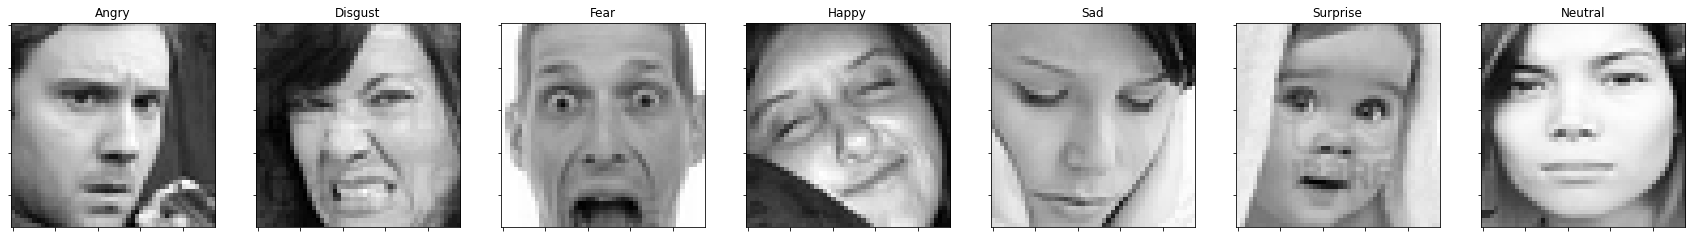

In [43]:
plot_all_emotions()

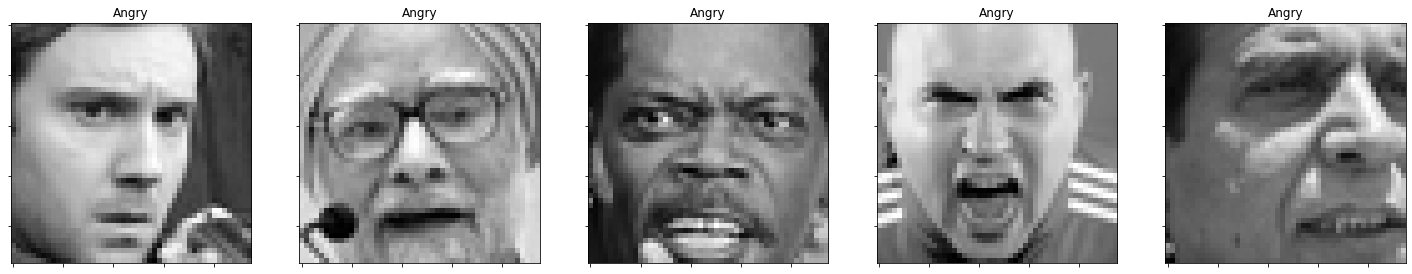

In [44]:
plot_examples(label=0)

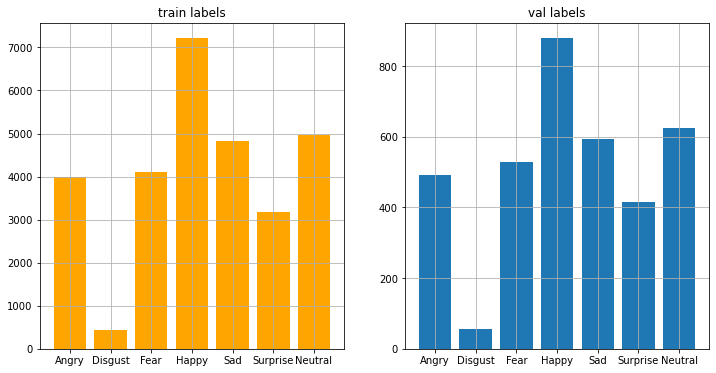

In [45]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [46]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [47]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [48]:
from tensorflow.keras.optimizers import SGD

model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\HP\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 4096)             

In [50]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)

Epoch 1/12
449/449 [==============================] - 125s 270ms/step - loss: 0.2662 - accuracy: 0.3202 - val_loss: 1.5929 - val_accuracy: 0.4048
Epoch 2/12
449/449 [==============================] - 108s 240ms/step - loss: 0.2260 - accuracy: 0.4373 - val_loss: 1.4241 - val_accuracy: 0.4611
Epoch 3/12
449/449 [==============================] - 85s 190ms/step - loss: 0.2062 - accuracy: 0.4878 - val_loss: 1.3671 - val_accuracy: 0.4751
Epoch 4/12
449/449 [==============================] - 86s 192ms/step - loss: 0.1936 - accuracy: 0.5239 - val_loss: 1.2939 - val_accuracy: 0.5104
Epoch 5/12
449/449 [==============================] - 83s 186ms/step - loss: 0.1836 - accuracy: 0.5464 - val_loss: 1.3197 - val_accuracy: 0.4979
Epoch 6/12
449/449 [==============================] - 83s 184ms/step - loss: 0.1754 - accuracy: 0.5668 - val_loss: 1.2836 - val_accuracy: 0.5194
Epoch 7/12
449/449 [==============================] - 83s 185ms/step - loss: 0.1675 - accuracy: 0.5873 - val_loss: 1.2344 - val_

In [51]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 3s 25ms/step - loss: 1.3944 - accuracy: 0.5347
test caccuracy: 0.5346893072128296


In [52]:
pred_test_labels = model.predict(test_images)

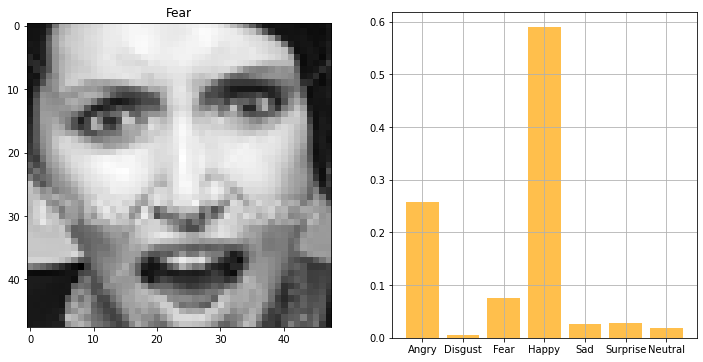

In [54]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 104)